### On Calibration of Modern Neural Networks

- Neural networks tend to output overconfident probabilities. Temperature scaling is a post-processing method that fixes it. 
- Calibrated confidence estimates are also important for model interpretability.
- For example, if we assign 80% confidence to 100 predictions, then we'd expect that 80% of the predictions are actually correct. If this is the case, we say the network is calibrated.

<img src=attachment:image.png width=550><br><center>**Reliability diagrams**</center>
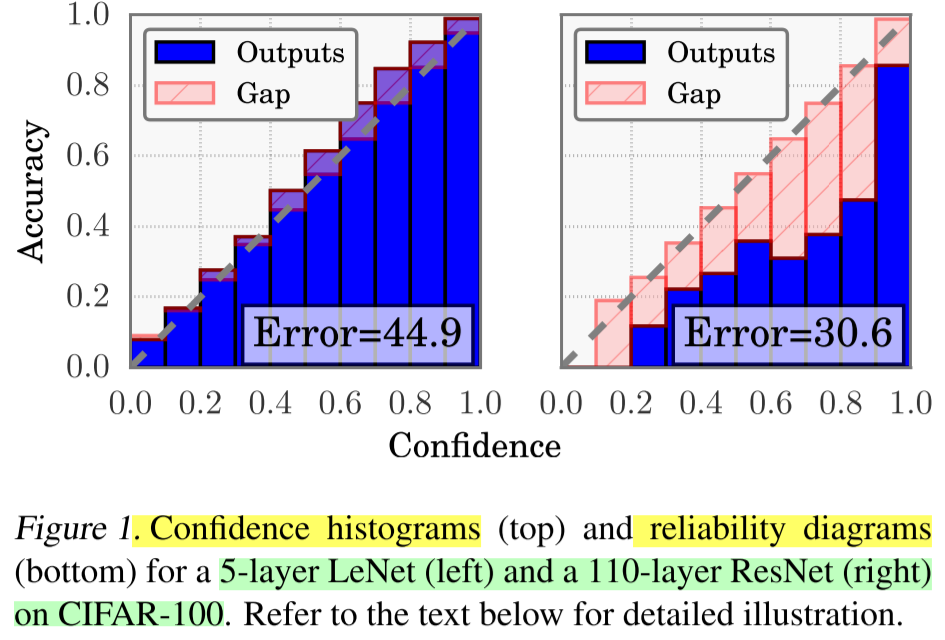

#### Reliability Diagrams
- Reliability Diagrams are a visual representation of model calibration. These diagrams plot expected sample accuracy as a function of confidence. If the model is perfectly calibrated then the diagram should plot the identity function.
- As you can see in fig. above, modern neural networks are no longer well-calibrated. What have made neural networks become miscalibrated?

#### Temperature scaling

-  We find that a single-parameter variant of Platt scaling (Platt et al., 1999) – which we refer to as **temperature scaling** – is often the most effective post-processing method at obtaining calibrated probabilities.

#### Expected Calibration Error (ECE)
$$\text{ECE} = \sum_{m=1}^{M} \frac{\lvert B_m \rvert}{n} \big\lvert \text{acc}(B_m) - \text{conf}(B_m) \big\rvert$$
where $B_m$ is bin. (e.g. a 80%-85% bin). We take a weighted average of the bins' $\vert \text{acc} - \text{conf} \vert$ difference. 
- The difference between acc and conf for a given bin represents the calibration gap
(red bars in reliability diagrams)

<img src= attachment:image.png width=700>
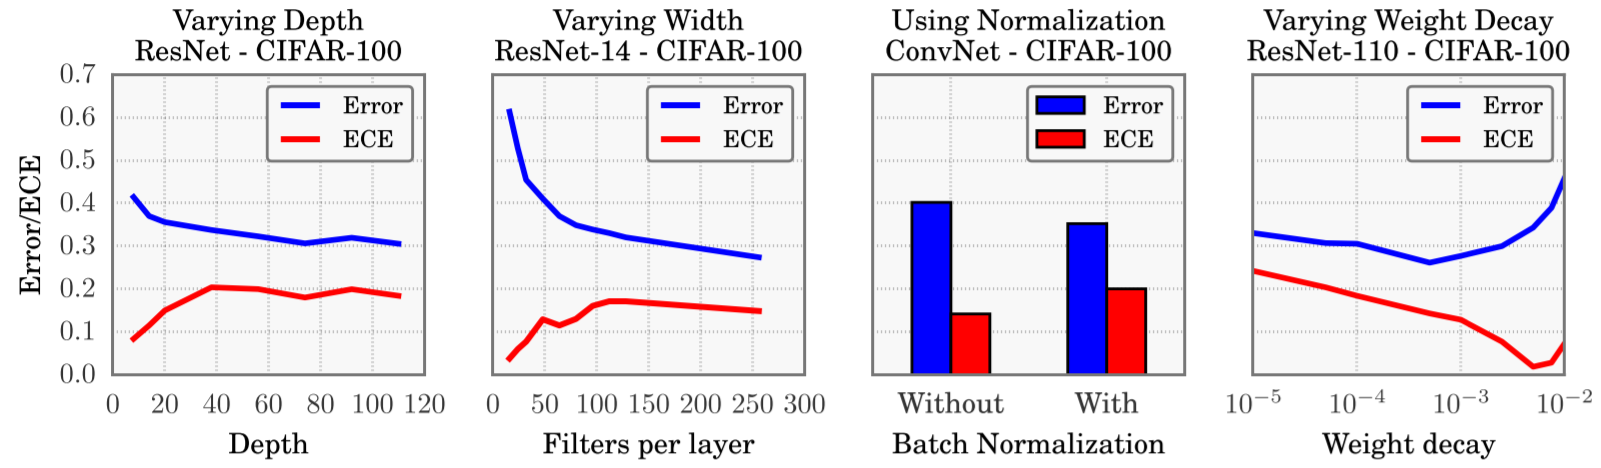

- Although increasing depth and width may reduce classification error, we observe that these increases negatively
affect model calibration. 

<img src=attachment:image.png width=450>
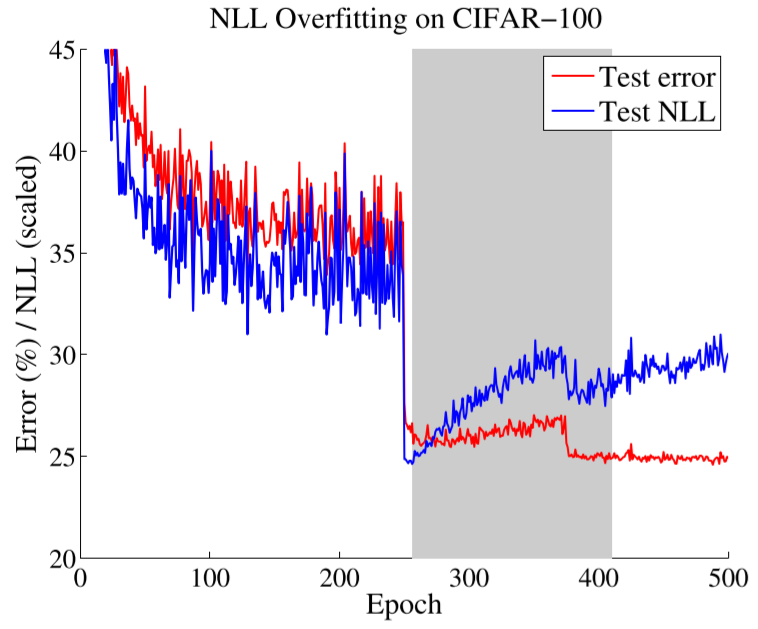

-  NNs can overfit to NLL without overfitting to the 0/1 loss.
- Surprisingly, overfitting to NLL is beneficial to classification accuracy. On CIFAR-100, test error drops from 29% to 27% in the region where NLL overfits. This phenomenon renders a concrete explanation of miscalibration: the network learns better classification
accuracy at the expense of well-modeled probabilities.
- There are two cases where NLL increases,
    1. Prediction is correct, and the model tries to reduce max softmax value. (and probably change the prediction)
    2. Prediction is wrong, and the model tries to increase max softmax value (output 0.95 even if the prediction is wrong)
- As seen in the graph, we can guess 2 is the case. (because accuracy didn't get worse.) 

#### Calibration Methods

- Platt scaling (Platt et al., 1999) : $ \hat{q} = \sigma (az + b) $
- Temperature scaling : $ \text{softmax}(\frac{\text{logits}}{\text{T}})$
    - $T$ is called the temperature, and it “softens” the softmax (i.e. raises the output entropy) with $T$ > 1.

- $T$ is optimized with respect to
NLL on the validation set. Temperature
scaling does not affect the model’s accuracy because the parameter $T$ does
not change the maximum of the softmax function.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0")

In [2]:
# MNIST dataset
cifar_train = datasets.CIFAR10(root='CIFAR10_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

cifar_test = datasets.CIFAR10(root='CIFAR10_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

0it [00:00, ?it/s]

 99%|█████████▉| 168894464/170498071 [00:13<00:00, 13615543.22it/s]

Files already downloaded and verified


In [3]:
learning_rate = 0.001
epochs = 15
batch_size = 128

valid_ratio = 0.1

In [4]:
num_train = len(cifar_train)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_ratio * num_train))

In [5]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          drop_last=True)

In [7]:
def vaild_loss(model_valid):
    avg_loss = 0
    with torch.no_grad():
        model_valid.eval()
        for images, labels in valid_loader:
            pred = model_valid(images.to(device))
            criterion = nn.CrossEntropyLoss().to(device)
            loss = criterion(pred, labels.to(device))
            avg_loss+= loss.item()
    
    return avg_loss / len(valid_loader)

In [8]:
class BasicCNN(nn.Module):
    
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(128*6*6, 10, bias=True)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1) # out.shape[0] : batch_size
        out = self.fc(out)
        return out

In [9]:
model = BasicCNN().to(device)

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# train my model
total_batch = len(train_loader)
model.train()
best_valid = np.inf

for epoch in range(epochs):
    avg_loss = 0

    for num, data in enumerate(train_loader):
        if num>39:
            break
        X, Y = data
        X = X.to(device) #img
        Y = Y.to(device) #label

        pred = model(X)
        loss = criterion(pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss / total_batch
    
    loss_valid = vaild_loss(model)
    print('Epoch:{}, train loss:{:.5f}, valid loss:{:.5f}'.format(epoch, avg_loss, loss_valid))

    if loss_valid < best_valid:
        torch.save(model.state_dict(), './saves/basicCNN.pth')
        best_valid = loss_valid

Epoch:0, train loss:0.16279, valid loss:1.58954
Epoch:1, train loss:0.15357, valid loss:1.55519
Epoch:2, train loss:0.14613, valid loss:1.50376
Epoch:3, train loss:0.14000, valid loss:1.43475
Epoch:4, train loss:0.13386, valid loss:1.40603
Epoch:5, train loss:0.12832, valid loss:1.38424
Epoch:6, train loss:0.12369, valid loss:1.36509
Epoch:7, train loss:0.11978, valid loss:1.34215
Epoch:8, train loss:0.11665, valid loss:1.32580
Epoch:9, train loss:0.11330, valid loss:1.34808
Epoch:10, train loss:0.10840, valid loss:1.33620
Epoch:11, train loss:0.10411, valid loss:1.32316
Epoch:12, train loss:0.10044, valid loss:1.31692
Epoch:13, train loss:0.09683, valid loss:1.31276
Epoch:14, train loss:0.09330, valid loss:1.31281


In [14]:
from temperature_scaling import ModelWithTemperature

In [15]:
temp_scaled_model = ModelWithTemperature(model)

# Tune the model temperature, and save the results
temp_scaled_model.set_temperature(valid_loader)
print('Done!')

Before temperature - NLL: 1.313, ECE: 0.056
Optimal temperature: 1.081
After temperature - NLL: 1.298, ECE: 0.033
Done!


-     def temperature_scale(self, logits): <br>
       >"Perform temperature scaling on logits"<br>        
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))<br>
        return logits / temperature<br>

- Next: optimize the temperature w.r.t. NLL
    - optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)